In [1]:
import os
gpu_num = 0 # 使用 "" 来启用 CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
import matplotlib.pyplot as plt
import numpy as np
import sionna

# Import Sionna RT components
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray
from mysionna.rt.scattering_pattern import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
scene = load_scene("./scenes/Indoor/indoor1.xml")
# scene = load_scene(sionna.rt.scene.etoile)

In [ ]:
scene.preview()

In [4]:
#################配置发端天线阵列#################
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

#################配置收端天线阵列#################
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

In [5]:
# ################创建发射机#########################
# tx = Transmitter(name="tx",
#                  position=[0,0,2.95])
# tx.look_at([-3.37234,2.18367,1.20838])
# ################ 将发射机加入到场景中##############
# scene.add(tx)
# #################创建接收机########################
# rx = Receiver(name="rx",
#               position=[0,0,2.95])
# rx.look_at([-3.37234,2.18367,1.20838])
# ################ 将接收机加入到场景中##############
# scene.add(rx)


In [6]:
scene.frequency = 6e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [7]:
scene.target_names = ["human1"]
scene.target_velocities = [(0.8,0,0.0)]

In [8]:
p1 = LambertianPattern()
p2 = DirectivePattern(20)
scene.get("itu_plywood").scattering_coefficient = 0.3
scene.get("itu_plywood").scattering_pattern = p1
scene.get("itu_concrete").scattering_coefficient = 0.5
scene.get("itu_concrete").scattering_pattern = p1
scene.get("itu_glass").scattering_coefficient = 0.25
scene.get("itu_glass").scattering_pattern = p2

In [14]:
crbs = scene.coverage_map_sensing(only_target=True,
                                  map_center=[0,0,2.95],
                                  map_size_x=10,
                                  map_size_y=6,
                                  cell_size=0.5,
                                  look_at=[-3.37234,2.18367,1.20838],
                                  batch_size=10,
                                  singleBS=True,
                                  num_samples=1000000,
                                  max_depth=3,
                                  diffraction=True,
                                  edge_diffraction=True,
                                  num_time_steps=1)

100%|██████████| 273/273 [01:35<00:00,  2.97it/s]

/tmp/ipykernel_161199/3711790770.py:14: RuntimeWarning: divide by zero encountered in log10
  crb = np.log10(crb)


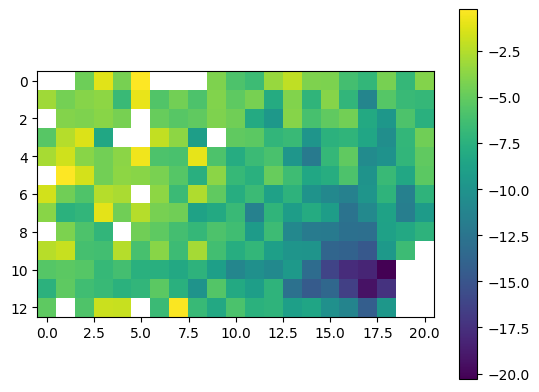

In [16]:
crb = None
for i in range(0,len(crbs)):
    c = crbs[i][0]
    c = tf.squeeze(c)
    # c = tf.linalg.diag_part(c)
    c = c.numpy()
    if crb is None:
        crb = c
    else:
        crb = np.concatenate((crb,c),axis=None)
crb = np.array(crb)
crb = np.reshape(crb,[-1,13])
# np.save("./Data/indoor/table1/crb.npy",crb)
crb = np.log10(crb)
crb = np.rot90(crb)
crb = np.flip(crb,axis=0)
crb = np.flip(crb,axis=1)
plt.imshow(crb)
plt.colorbar()


In [9]:
paths = scene.compute_paths(max_depth=2,reflection=True,diffraction=True,scattering=True,edge_diffraction=True)
paths.normalize_delays = False

In [37]:
scene.preview(paths=paths)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

Text(0, 0.5, '$|a|$')

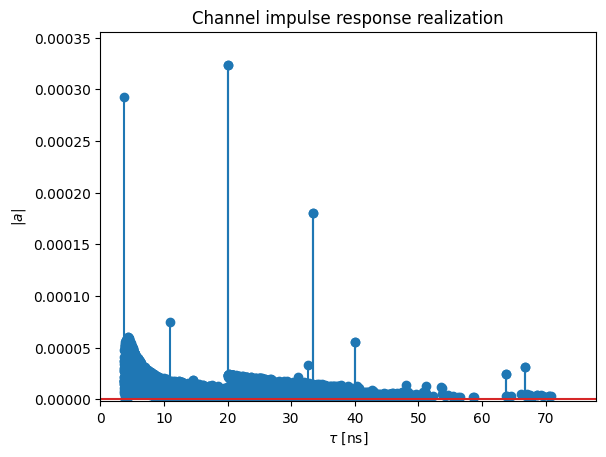

In [10]:
a, tau = paths.cir()
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
t = t[a_abs!=0]
a_abs = a_abs[a_abs!=0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")

In [11]:
v,obj=scene.compute_target_velocities(paths, return_obj_names=True)

In [10]:
subcarrier_spacing = 15e3
num_time_steps = 1
paths.apply_doppler(sampling_frequency=subcarrier_spacing, num_time_steps=num_time_steps,target_velocities=v)

In [11]:
crb = paths.crb_delay()

In [12]:
paths.export_crb(crb,"test.xyzrgb",BS_pos = [0,0,2.95])

True

/tmp/ipykernel_84760/3546195330.py:35: RuntimeWarning: divide by zero encountered in log10
  crb = np.log10(crb)
/tmp/ipykernel_84760/3546195330.py:55: RuntimeWarning: divide by zero encountered in log10
  mse = np.log10(mse)


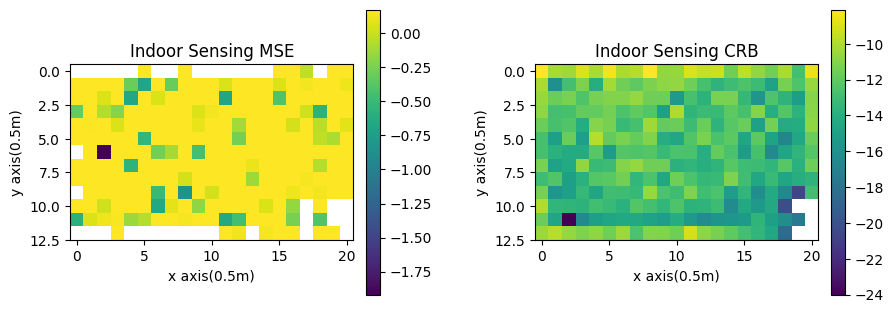

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
scene_name = "indoor"
target = "human1"
#read config and turn it to global variables
config = json.load(open("crb_validation_config.json"))
subcarrier_spacing = config.get("subcarrier_spacing")
subcarrier_num = config.get("subcarrier_num")
num_time_steps = config.get("num_time_steps")
ebno_db = config.get("ebno_db")
num_samples = config.get("num_samples")
batch_size = config.get("batch_size")
max_depth = config.get("max_depth")
step = config.get("step")
los = config.get("los")
reflection = config.get("reflection")
scattering = config.get("scattering")
diffraction = config.get("diffraction")
edge_diffraction = config.get("edge_diffraction")
ray_type = "TTTTT"
x = 10
y = 6
cell_size = 0.5
col = int(y/cell_size)+1
title = f"{num_samples}-{ray_type}-{max_depth}-{step}-{batch_size}-{x}-{y}-{cell_size}"
with open(f"./Data/{scene_name}/{target}/{title}/tau_true.txt","r") as f:
    tau_true = f.readlines()
    tau_true = np.array([float(i) for i in tau_true])
with open(f"./Data/{scene_name}/{target}/{title}/tau_est.txt","r") as f:
    tau_est = f.readlines()
    tau_est = np.array([float(i) for i in tau_est])
crb = np.load(f"./Data/{scene_name}/{target}/{title}/crb.npy")
crb = crb*3e8
crb = np.log10(crb)
crb = np.reshape(crb,(-1,col))

pad = 0

mse = np.abs(tau_true-tau_est)
mse = np.reshape(mse,(-1,col))
tau_true = np.reshape(tau_true,(-1,col))
tau_est = np.reshape(tau_est,(-1,col))
mask = mse >= 1
mse[mask] = pad
mask = tau_est==0
mse[mask] = pad
mask = tau_true==999999 
mse[mask] = pad
mask = tau_true==0
mse[mask] = pad
mask = tau_true==-1
mse[mask] = pad
mse = mse*3e8
mse = np.log10(mse)
# 逆时针旋转九十度
mse = np.rot90(mse)
crb = np.rot90(crb)
# x轴对称
mse = np.flip(mse,1)
crb = np.flip(crb,1)
mse = np.flip(mse,0)
crb = np.flip(crb,0)
# set figure size
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.title("Indoor Sensing MSE")
plt.xlabel("x axis(0.5m)")
plt.ylabel("y axis(0.5m)")
plt.imshow(mse)
# set colorbar size
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.title("Indoor Sensing CRB")
plt.xlabel("x axis(0.5m)")
plt.ylabel("y axis(0.5m)")
plt.imshow(crb)
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig(f"./Data/{scene_name}/{target}/out.png")

In [4]:
import mitsuba as mi
scene_params = mi.traverse(scene._scene)
scene_params

SceneParameters[
  ----------------------------------------------------------------------------------------------
  Name                                       Flags    Type           Parent
  ----------------------------------------------------------------------------------------------
  camera.near_clip                                    float          PerspectiveCamera
  camera.far_clip                                     float          PerspectiveCamera
  camera.shutter_open                                 float          PerspectiveCamera
  camera.shutter_open_time                            float          PerspectiveCamera
  camera.film.size                                    ScalarVector2u HDRFilm
  camera.film.crop_size                               ScalarVector2u HDRFilm
  camera.film.crop_offset                             ScalarPoint2u  HDRFilm
  camera.x_fov                               ∂, D     Float          PerspectiveCamera
  camera.principal_point_offset_x            ∂,

In [5]:
human = mi.load_dict({'type': 'ply',
                    'filename': './scenes/Indoor/meshes/human1.ply'})
human

PLYMesh[
  name = "human1.ply",
  bbox = BoundingBox3f[
    min = [-3.68708, 1.85568, -0.0123519],
    max = [-3.0576, 2.51166, 2.42912]
  ],
  vertex_count = 14,
  vertices = [448 B of vertex data],
  face_count = 12,
  faces = [144 B of face data],
  face_normals = 0
]

In [6]:
scene._scene.shapes()

[PLYMesh[
   name = "ceiling.ply",
   bbox = BoundingBox3f[
     min = [-5, -3, 3.5],
     max = [5, 3, 3.5]
   ],
   vertex_count = 4,
   vertices = [80 B of vertex data],
   face_count = 2,
   faces = [24 B of face data],
   face_normals = 1
 ],
 PLYMesh[
   name = "door.ply",
   bbox = BoundingBox3f[
     min = [-4.51779, 1.56861, -0.00357819],
     max = [-4.04366, 3.04818, 3.14076]
   ],
   vertex_count = 14,
   vertices = [280 B of vertex data],
   face_count = 12,
   faces = [144 B of face data],
   face_normals = 1
 ],
 PLYMesh[
   name = "floor.ply",
   bbox = BoundingBox3f[
     min = [-5, -3, 0],
     max = [5, 3, 0]
   ],
   vertex_count = 4,
   vertices = [80 B of vertex data],
   face_count = 2,
   faces = [24 B of face data],
   face_normals = 1
 ],
 PLYMesh[
   name = "table1.ply",
   bbox = BoundingBox3f[
     min = [-1.95782, -1.07471, 1.20652],
     max = [1.95782, 0.925293, 1.31491]
   ],
   vertex_count = 14,
   vertices = [280 B of vertex data],
   face_count = 12